In [ ]:
%run C:\Users\Omar\Intern_Final_Project\notebooks\Data_Cleaning\Features_Engineering.ipynb

### *cross validation*

*We will keep the last 16 rows of the dataset and do a Rolling Moving Origin of step size of 4*


*lets explain this visually*

In [312]:
from sklearn.model_selection import TimeSeriesSplit

In [313]:
test_data_red=df_red[-16:]
#####
X = test_data_red.drop("price",axis=1)
y = test_data_red["price"]
date=test_data_red.reset_index()["week_end_dt"]
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[4 5 6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[ 8  9 10 11]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14 15]


The above code out come expresess how the cross validation works ,
1st fold : we consider the 4 intial points as train data and the next 4 points as test data
2ns fold : the test points from the prevuoys fold we be appened to the new train points asnd new points ahead are test points
3rd fold : works as metioned above

The below chart is ease the process:


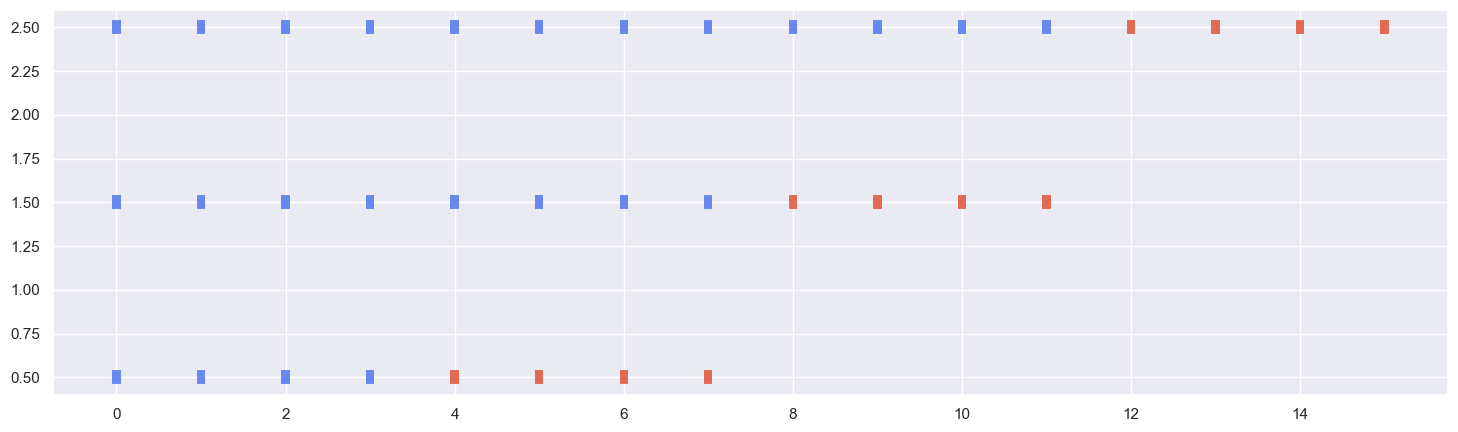

In [314]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, n_splits, X, y):
    fig, ax = plt.subplots(1, 1, figsize = (18, 5))
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
plot_cv_indices(cv=tscv,n_splits=3,X=X,y=y)

---
importing needed libraries

In [315]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_tree,plot_importance,XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm.sklearn import LGBMRegressor
import warnings                                  
warnings.filterwarnings('ignore')

In [316]:
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)

In [ ]:
mape_scores = []
y_pred_red_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                    "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
                XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]

test_data_red=df_red  
time_series_data_red = test_data_red.values

for train_index, test_index in tscv.split(time_series_data_red):
              X_train, y_train = time_series_data_red[train_index, 1:], time_series_data_red[train_index, 0]
              X_test, y_test = time_series_data_red[test_index, 1:], time_series_data_red[test_index, 0]

        
for model in models:
              model.fit(X_train, y_train)
              y_pred_red = model.predict(X_test)
              y_pred_red_results.append(y_pred_red)

              mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_red))
              mape_scores.append(mape)

              mape_red=pd.concat([pd.DataFrame(models_names,columns=["models_names"]),pd.DataFrame(mape_scores,columns=["mape_scores"])],axis=1)

In [318]:
from datetime import datetime,timedelta
new_date_index=pd.date_range(start="2023-09-10",end="2023-10-01",freq="W")
new_date_index=pd.DataFrame({"date":new_date_index})

In [319]:

pred_results_red=pd.DataFrame(y_pred_red_results).T
pred_results_red.columns=models_names
pred_results_red=pd.concat([pred_results_red,new_date_index],axis=1).set_index("date")

In [ ]:
mape_scores = []
y_pred_green_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                    "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
                XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]
     
test_data_green=df_green[-16:]
time_series_data_green = test_data_green.values

for train_index, test_index in tscv.split(time_series_data_green):
              X_train, y_train = time_series_data_green[train_index, 1:], time_series_data_green[train_index, 0]
              X_test, y_test = time_series_data_green[test_index, 1:], time_series_data_green[test_index, 0]
        
        
for model in models:
              model.fit(X_train, y_train)
              y_pred_green = model.predict(X_test)
              y_pred_green_results.append(y_pred_green)

              mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_green))
              mape_scores.append(mape)

              mape_green =pd.concat([pd.DataFrame(models_names,columns=["models_names"]),pd.DataFrame(mape_scores,columns=["mape_scores"])],axis=1)

In [321]:
pred_results_green=pd.DataFrame(y_pred_green_results).T
pred_results_green.columns=models_names
pred_results_green=pd.concat([pred_results_green,new_date_index],axis=1).set_index("date")

In [ ]:
mape_scores = []
y_pred_yellow_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
            XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]
     
test_data_yellow=df_yellow[-16:]
time_series_data_yellow = test_data_yellow.values

for train_index, test_index in tscv.split(time_series_data_yellow):
              X_train, y_train = time_series_data_yellow[train_index, 1:], time_series_data_yellow[train_index, 0]
              X_test, y_test = time_series_data_yellow[test_index, 1:], time_series_data_yellow[test_index, 0]
        

for model in models:
              model.fit(X_train, y_train)
              y_pred_yellow = model.predict(X_test)
              y_pred_yellow_results.append(y_pred_yellow)

              mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_yellow))
              mape_scores.append(mape)

              mape_yellow=pd.concat([pd.DataFrame(models_names,columns=["models_names"]),pd.DataFrame(mape_scores,columns=["mape_scores"])],axis=1)

In [323]:
pred_results_yellow=pd.DataFrame(y_pred_yellow_results).T
pred_results_yellow.columns=models_names
pred_results_yellow=pd.concat([pred_results_yellow,new_date_index],axis=1).set_index("date")

In [324]:
mape_red.sort_values(by="mape_scores")

,models_names,mape_scores
5,XGBRFRegressor_boo,0.038814
3,LinearRegression,0.039803
4,XGBRegressor_boo,0.041372
6,AdaBoostRegressor_boo,0.051380
1,RandomForestRegressor,0.056584
8,CatBoostRegressor_boo,0.065991
0,DecisionTreeRegressor,0.090173
2,SVR(),0.091439
7,LGBMRegressor_boo,0.125801


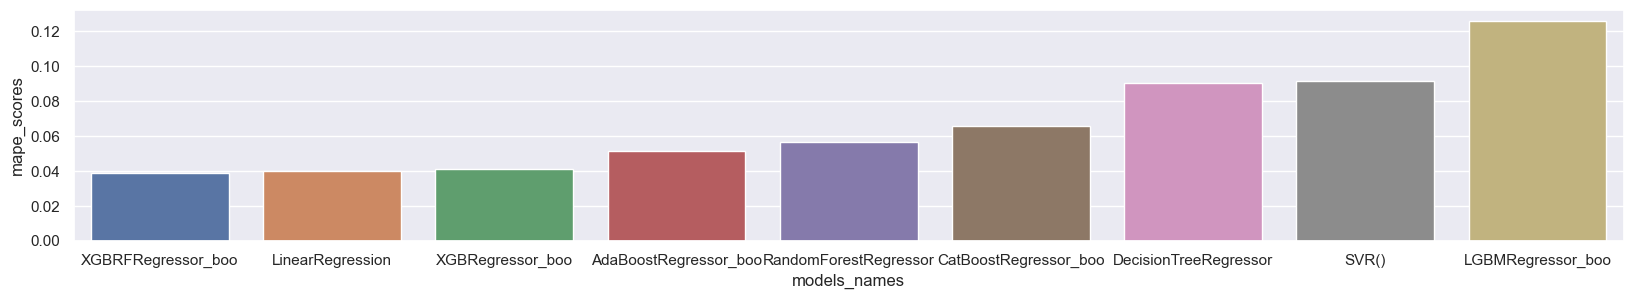

In [325]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=mape_red.sort_values(by="mape_scores"),x="models_names",y="mape_scores");

In [326]:
mape_green.sort_values(by="mape_scores")

,models_names,mape_scores
6,AdaBoostRegressor_boo,0.004631
5,XGBRFRegressor_boo,0.014620
1,RandomForestRegressor,0.015183
4,XGBRegressor_boo,0.023848
8,CatBoostRegressor_boo,0.026216
3,LinearRegression,0.051920
2,SVR(),0.064283
0,DecisionTreeRegressor,0.081300
7,LGBMRegressor_boo,0.092160


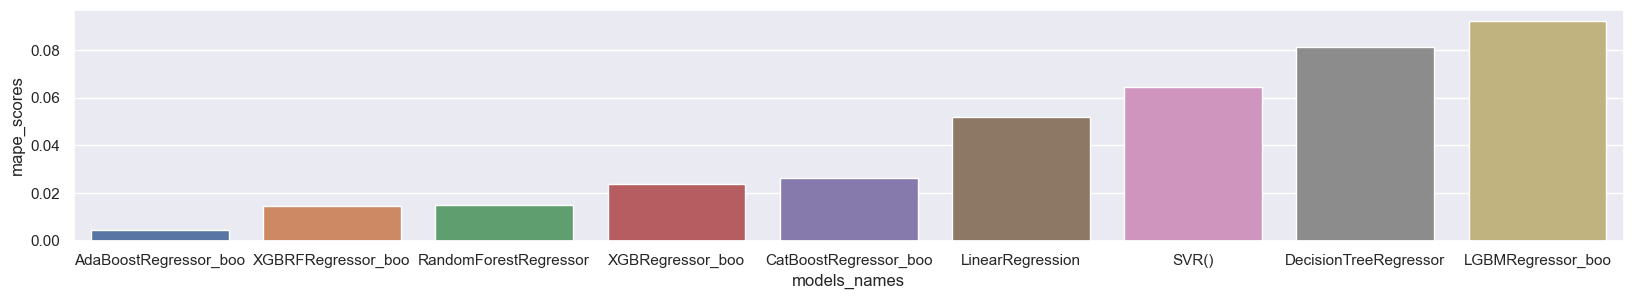

In [327]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=mape_green.sort_values(by="mape_scores"),x="models_names",y="mape_scores");

In [328]:
mape_yellow.sort_values(by="mape_scores")

,models_names,mape_scores
0,DecisionTreeRegressor,0.061649
6,AdaBoostRegressor_boo,0.061649
5,XGBRFRegressor_boo,0.091078
1,RandomForestRegressor,0.108369
4,XGBRegressor_boo,0.120677
8,CatBoostRegressor_boo,0.122763
3,LinearRegression,0.156728
7,LGBMRegressor_boo,0.205554
2,SVR(),0.210638


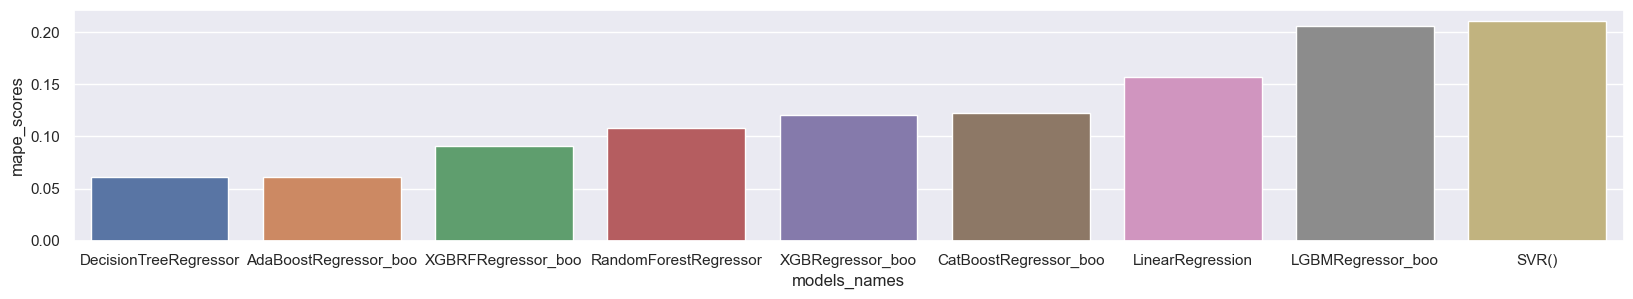

In [329]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=mape_yellow.sort_values(by="mape_scores"),x="models_names",y="mape_scores");

* *Results*
1. *The lowest mean mape score for red color is XGBRFRegressor with 0.038814 score*
2. *The lowest mean mape score for green color is AdaBoostRegressor with 0.004631 score*
3. *The lowest mean mape score for yellow color is DecisionTreeRegressor with 0.061649 score*

 

In [330]:
pred_results_red

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
date,,,,,,,,,
2023-09-10,7.209757,7.239061,7.665649,6.966725,6.982857,7.067555,7.209757,7.901178,7.349349
2023-09-17,7.514575,7.319638,7.652329,7.032121,6.985954,7.209729,7.209757,7.901178,7.466486
2023-09-24,7.514575,7.487486,7.654487,7.022051,6.985239,7.323184,7.331730,7.901178,7.481343
2023-10-01,8.405730,7.635938,7.667752,6.927633,7.633429,7.561815,7.782990,7.901178,7.638877


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


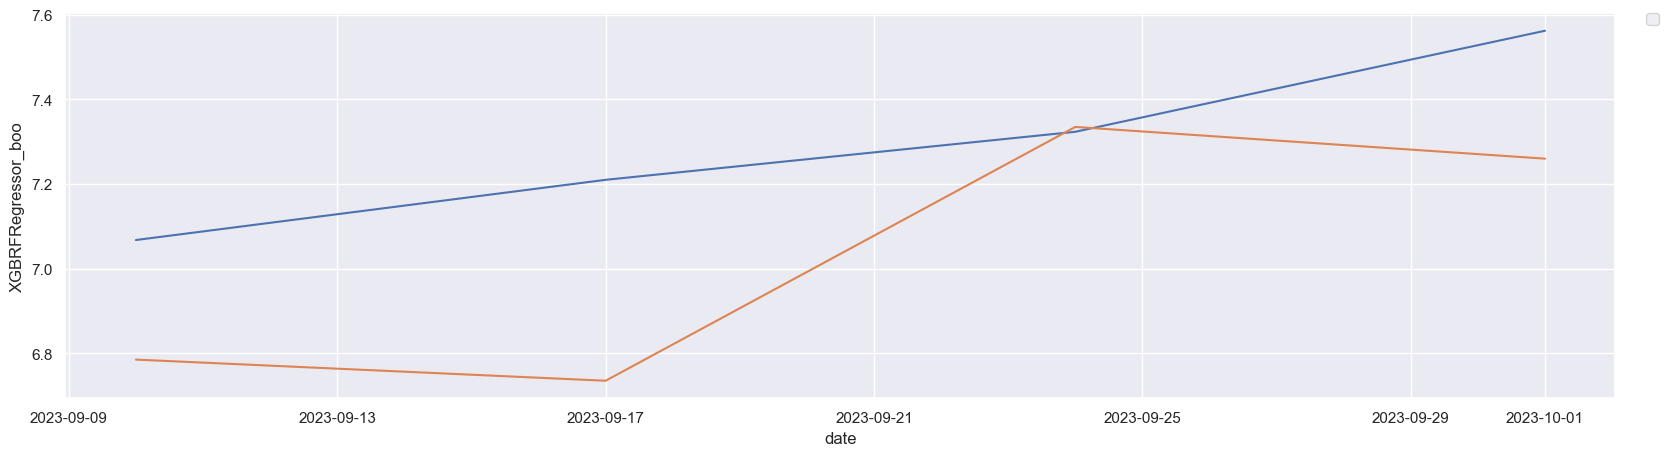

In [331]:
fig, ax = plt.subplots(1, 1, figsize = (20,5))
sns.lineplot(pred_results_red['XGBRFRegressor_boo'],legend=True)
sns.lineplot(test_data_red[-4:]["price"],legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [332]:
pred_results_green

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
date,,,,,,,,,
2023-09-10,6.885049,6.730250,7.167261,6.282252,6.560656,6.741680,6.560342,7.372297,6.759338
2023-09-17,6.885049,6.815803,7.170680,6.307334,6.560656,6.819746,6.560342,7.372297,6.958623
2023-09-24,7.732530,6.892940,7.191284,7.277664,6.598741,6.916177,6.885049,7.372297,6.984769
2023-10-01,7.732530,6.945625,7.208712,7.343022,6.640180,6.895199,6.885049,7.372297,7.013553


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


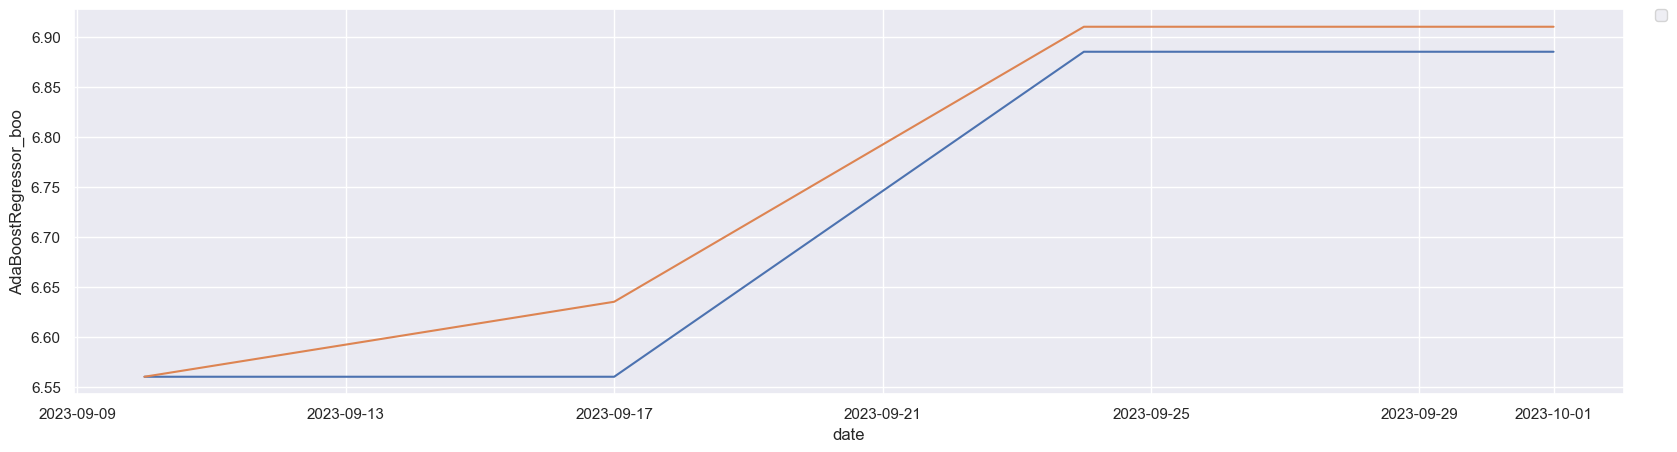

In [333]:
fig, ax = plt.subplots(1, 1, figsize = (20,5))
sns.lineplot(pred_results_green['AdaBoostRegressor_boo'],legend=True)
sns.lineplot(test_data_green[-4:]["price"],legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [334]:
pred_results_yellow

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
date,,,,,,,,,
2023-09-10,9.432754,9.792827,10.795877,9.099346,9.992828,9.701227,9.432754,10.711343,9.749893
2023-09-17,9.432754,10.054038,10.790009,8.380169,10.216381,9.834319,9.432754,10.711343,10.153165
2023-09-24,9.432754,9.763172,10.745630,7.538567,10.192812,9.634562,9.432754,10.711343,9.975829
2023-10-01,9.432754,9.778543,10.695368,5.223640,9.435352,9.605927,9.432754,10.711343,10.019202


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


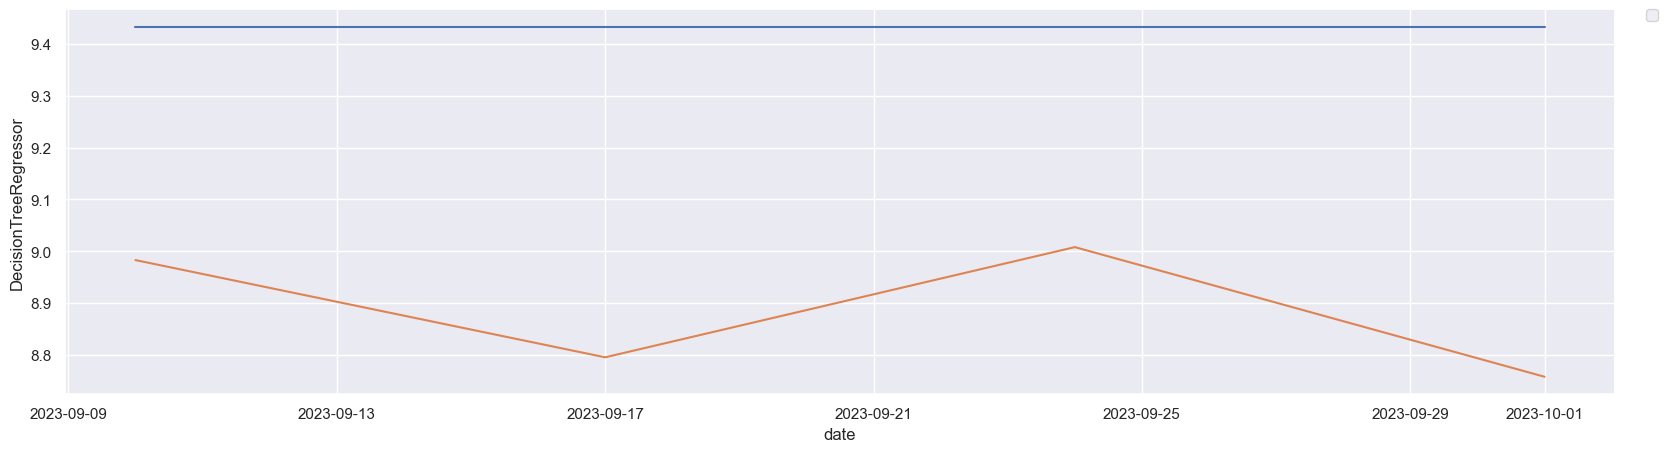

In [335]:
fig, ax = plt.subplots(1, 1, figsize = (20,5))
sns.lineplot(pred_results_yellow['DecisionTreeRegressor'],legend=True)
sns.lineplot(test_data_yellow[-4:]["price"],legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

---

###  *Hyperparamers tunning*